# SARSA Frozen Lake
Implementation of a SARSA agent to learn policies in the Frozen Lake environment from OpenAI gym.

In [1]:
#! /usr/bin/env python
# __author__ = 'Ning Shi'
# __email__ = 'MrShininnnnn@gmail.com'

In [2]:
# define path
RESULT_IMG_PATH = 'img/result_img_{}.png'

In [3]:
# import dependency
import gym # OpenAI Game Environment
import gym.envs.toy_text # Customized Map
import numpy as np
from tqdm import trange # Processing Bar
import matplotlib.pyplot as plt
%matplotlib inline

## Problem - Frozen Lake

[Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0/) is an environment where an agent is able to move a character in a grid world. Starting from the state *S*, the agent aims to move the character to the goal state *G* for a reward of 1. Although the agent can pick one of four possible actions at each state including *left*, *down*, *right*, *up*, it only succeeds $\frac{1}{3}$ of the times due to the slippery frozen state *F*. The agent is likely to move to any other directions for the remaining $\frac{2}{3}$ times evenly. Additionally, stepping in a hole state *H* will lead to a bad ending with a reward of 0.

+ S: Start State
+ G: Goal State
+ F: Frozen Surface
+ H: Hole State

![Frozen Lake](img/frozen_lake_0.png)

In [4]:
# initialization
amap='SFFFHFFFG'
grid_shape = np.int(np.sqrt(len(amap)))
custom_map = np.array(list(amap)).reshape(grid_shape, grid_shape)
env = gym.envs.toy_text.frozen_lake.FrozenLakeEnv(desc=custom_map).unwrapped
# env = gym.make('FrozenLake-v0')
n_states, n_actions = env.observation_space.n, env.action_space.n
print('{} states'.format(n_states))
print('{} actions'.format(n_actions))
env.render()    

9 states
4 actions

SFF
FHF
FFG


In [5]:
# take a look
done = False
env.reset()
while not done:
    # randomly pick an action
    action = np.random.randint(n_actions)
    # get feedback from the environment
    obvervation, reward, done, info = env.step(action)
    # show the environment
    env.render()

  (Up)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG


## Random Strategy

In [6]:
# experiment settings
n_episodes = 100
reward_array = np.zeros(n_episodes)

In [7]:
# performance of an agent taking random actions
t = trange(n_episodes)
# for each episode
for i in t:
    # reset environment
    env.reset()
    # done flag
    done = False
    while not done:
        # randomly pick an action
        action = np.random.randint(n_actions)
        # get feedback from the environment
        _, reward, done, _ = env.step(action)
        if done:
            # update processing bar
            t.set_description('Episode {} Reward {}'.format(i + 1, reward))
            t.refresh()
            reward_array[i] = reward
            break
env.close()

Episode 100 Reward 0.0: 100%|██████████| 100/100 [00:00<00:00, 442.43it/s]


In [8]:
# averaged reward per episode
avg_reward = round(np.mean(reward_array), 4)
print('Averaged reward per episode {}'.format(avg_reward))

Averaged reward per episode 0.11


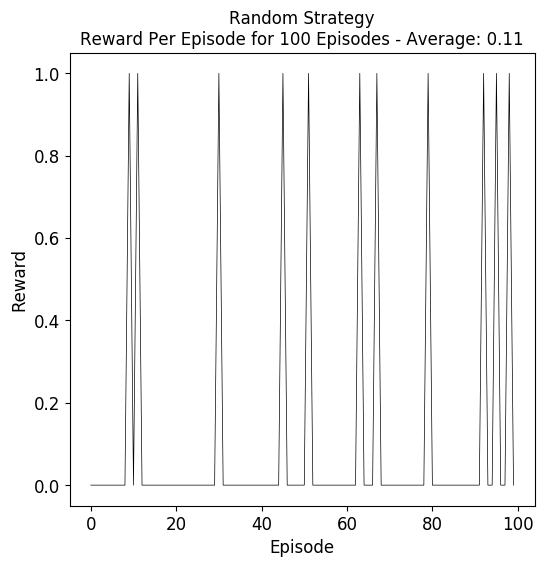

In [9]:
# show reward per episode
plt.subplots(figsize = (6, 6), dpi=100)
plt.plot(reward_array, color='black', linewidth=0.5)
plt.ylabel('Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Random Strategy\nReward Per Episode for {} Episodes - Average: {:.2f}'.format(n_episodes, avg_reward), 
          fontsize=12)
plt.savefig(RESULT_IMG_PATH.format(0), dpi=100, bbox_inches='tight')
plt.show()

## State Action Reward State Action (SARSA)

[State Action Reward State Action (SARSA)](https://en.wikipedia.org/wiki/State%E2%80%93action%E2%80%93reward%E2%80%93state%E2%80%93action) is a classic method learning a Markov Decision Process (MDP) policy to solve problems in the field of reinforcement learning. As indicated by the name SARSA, it updates the $Q(s_{t}, a_{t})$, according to the current state $s_{t}$, the action choose $a_{t}$, the reward $r_{t}$ due to this action, the new state $s_{t+1}$ after taking this action, and the action $a_{t+1}$ picked for this new state.
Given that, the Q-value table can be updated by:

$$Q(s_{t}, a_{t}) \leftarrow Q(s_{t}, a_{t}) + \alpha[r_{t} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t})]$$

where, $\alpha$ stands for the learning rate and $\gamma$ represents the discount factor. It can be seen in the definition that the SARSA method aims to update the policy through interactions with the environment, so it belongs to the on-policy learning algorithm family.

### Training

In [10]:
# initialize the agent’s Q-table to zeros
def init_q(s, a):
    """
    s: number of states
    a: number of actions
    """
    return np.zeros((s, a))

# epsilon-greedy exploration strategy
def epsilon_greedy(Q, epsilon, n_actions, s):
    """
    Q: Q Table
    epsilon: exploration parameter
    n_actions: number of actions
    s: state
    """
    # selects a random action with probability epsilon
    if np.random.random() <= epsilon:
        return np.random.randint(n_actions)
    else:
        return np.argmax(Q[s, :])
    
# SARSA Process
def sarsa(alpha, gamma, epsilon, n_episodes):
    """
    alpha: learning rate
    gamma: exploration parameter
    n_episodes: number of episodes
    """
    # initialize Q table
    Q = init_q(n_states, n_actions)
    t = trange(n_episodes)
    reward_array = np.zeros(n_episodes)
    for i in t:
        # initial state
        s = env.reset()
        # initial action
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        done = False
        while not done:
            s_, reward, done, _ = env.step(a)
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            # update Q table
            Q[s, a] += alpha * (reward + (gamma * Q[s_, a_]) - Q[s, a])
            if done:
                t.set_description('Episode {} Reward {}'.format(i + 1, reward))
                t.refresh()
                reward_array[i] = reward
                break
            s, a = s_, a_
    env.close()
    return Q, reward_array

In [11]:
# experiment settings
alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon=0.5 # exploration parameter
n_episodes = 1000 # number of training episodes

In [12]:
# training
Q, reward_array = sarsa(alpha, gamma, epsilon, n_episodes)

Episode 1000 Reward 0.0: 100%|██████████| 1000/1000 [00:02<00:00, 406.65it/s]


In [13]:
# show Q table
Q

array([[0.11127599, 0.11134092, 0.11662594, 0.11426272],
       [0.07594323, 0.06582293, 0.08587472, 0.18308739],
       [0.22516831, 0.33554307, 0.30837696, 0.21529977],
       [0.13835196, 0.11392035, 0.10753916, 0.07451863],
       [0.        , 0.        , 0.        , 0.        ],
       [0.38844232, 0.46961241, 0.61050578, 0.22461087],
       [0.208509  , 0.29929826, 0.2483833 , 0.25886936],
       [0.17782283, 0.37645654, 0.47811499, 0.33509296],
       [0.        , 0.        , 0.        , 0.        ]])

In [14]:
# averaged reward per episode
avg_reward = round(np.mean(reward_array), 4)
print('Averaged reward per episode {}'.format(avg_reward))

Averaged reward per episode 0.301


### Testing

In [15]:
def eva(Q, n_episodes):
    """
    Q: trained Q table
    n_episodes: number of episodes
    """
    t = trange(n_episodes)
    reward_array = np.zeros(n_episodes)
    for i in t:
        # initial state
        s = env.reset()
        # initial action
        a = np.argmax(Q[s])
        done = False
        while not done:
            s_, reward, done, _ = env.step(a)
            # pick an action according the state and trained Q table
            a_ = np.argmax(Q[s_])
            if done:
                t.set_description('Episode {} Reward {}'.format(i + 1, reward))
                t.refresh()
                reward_array[i] = reward
                break
            s, a = s_, a_
    env.close()
    return reward_array

In [16]:
# experiment settings
n_episodes = 100 # number of testing episodes
reward_array = eva(Q, n_episodes)

Episode 100 Reward 1.0: 100%|██████████| 100/100 [00:00<00:00, 411.81it/s]


In [17]:
# averaged reward per episode
avg_reward = round(np.mean(reward_array), 4)
print('Averaged reward per episode {}'.format(avg_reward))

Averaged reward per episode 0.72


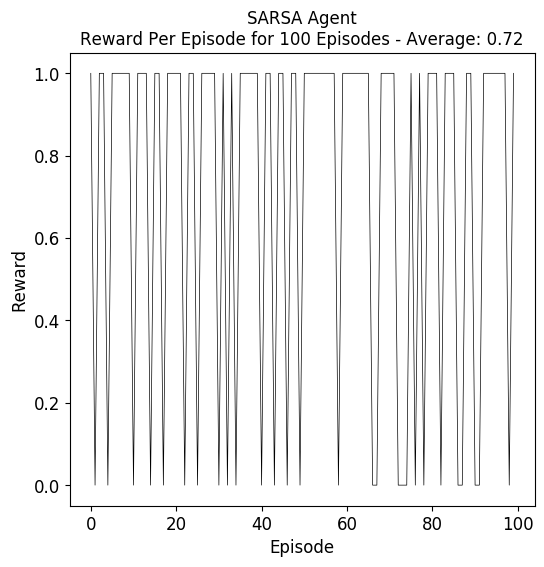

In [18]:
# show reward per episode
plt.subplots(figsize = (6, 6), dpi=100)
plt.plot(reward_array, color='black', linewidth=0.5)
plt.ylabel('Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('SARSA Agent\nReward Per Episode for {} Episodes - Average: {:.2f}'.format(n_episodes, avg_reward), 
          fontsize=12)
plt.savefig(RESULT_IMG_PATH.format(1), dpi=100, bbox_inches='tight')
plt.show()

In [19]:
# trained SARSA agent in Frozen Lake
done = False
s = env.reset()
env.render()
while not done:
    # pick an action
    a = np.argmax(Q[s])
    # get feedback from the environment
    s_, _, done, _ = env.step(a)
    # show the environment
    env.render()
    s = s_


SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Left)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Down)
SFF
FHF
FFG
  (Down)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Left)
SFF
FHF
FFG
  (Left)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Left)
SFF
FHF
FFG
  (Left)
SFF
FHF
FFG
  (Left)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Down)
SFF
FHF
FFG
  (Down)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Down)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Left)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Left)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Down)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Down)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Down)
SFF
FHF
FFG
  (Up)
SFF
FHF
FFG
  (Down)
SFF
FHF
FFG
  (Down)
SFF
FHF
FFG
  (Right)
SFF
FHF
FFG
  (Righ